In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)
warnings.filterwarnings(action= 'ignore')

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43547,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40981,Total threads: 4
Dashboard: /proxy/44087/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:32831,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform.db'
session_pos20W = cc.database.create_session(db)

expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos20W']
session = [session_cont, session_pos20W]
name = ['Control', '+20W/m2']

In [5]:
start_time = '2202-01-01'
end_time = '2301-12-31'

start_time_last = '2291-01-01'
end_time_last = end_time

In [6]:
ncoarse = 12

x_min = [-100, -250, -70, -220, -70, -250]
x_max = [ 10 , -100,  20, -80 ,  20, -80 ]
y_min = [ 20 ,  20 , -42 ,-37 , -80, -80 ]
y_max = [ 75 ,  75 , -20, -20 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP', 'WG', 'RG']

## KPP Depth

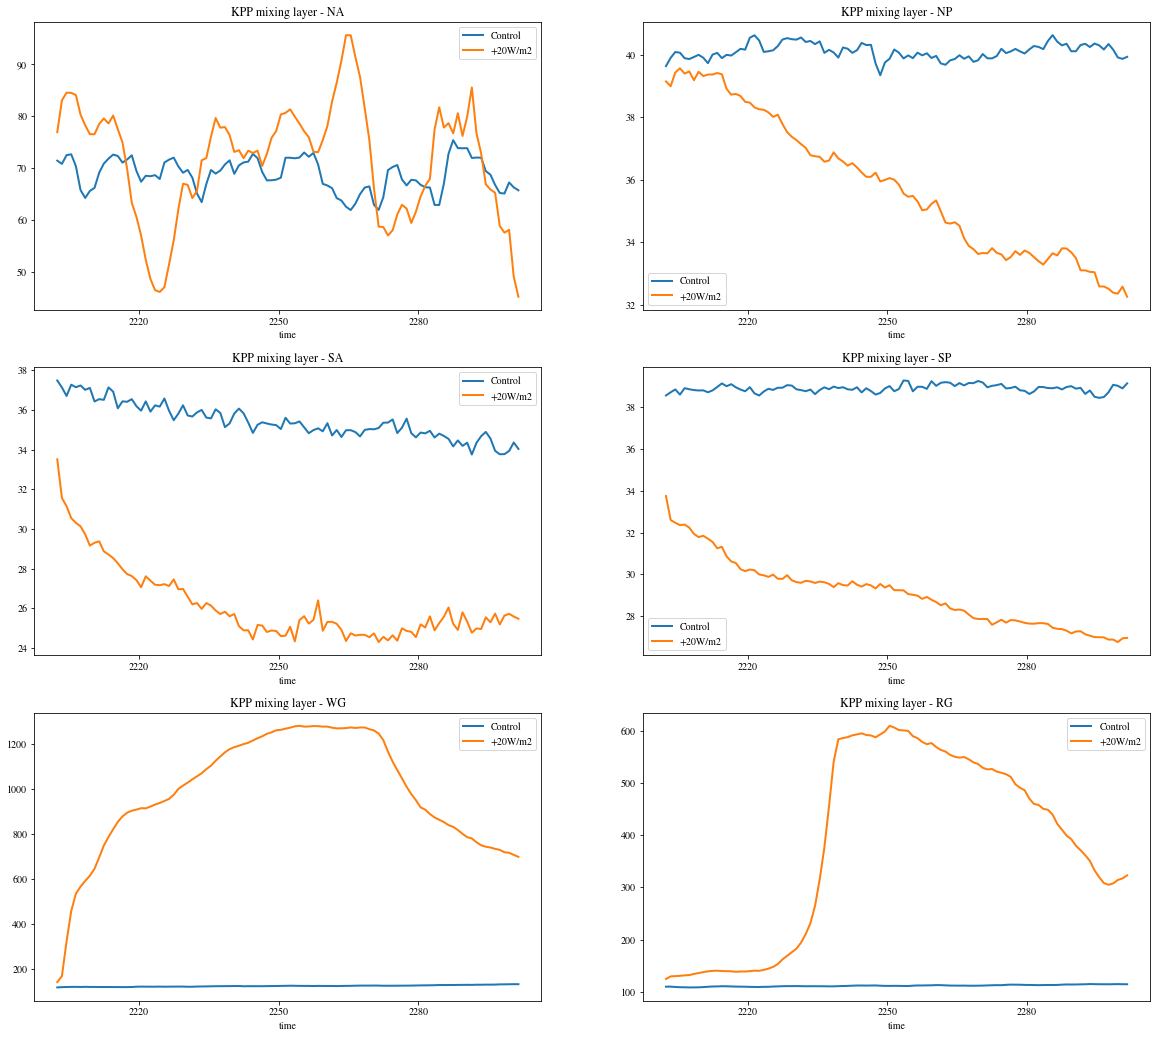

In [7]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

for i, j in enumerate(session):
    
    hblt = cc.querying.getvar(expt = expt[i], session = j, variable = 'hblt', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

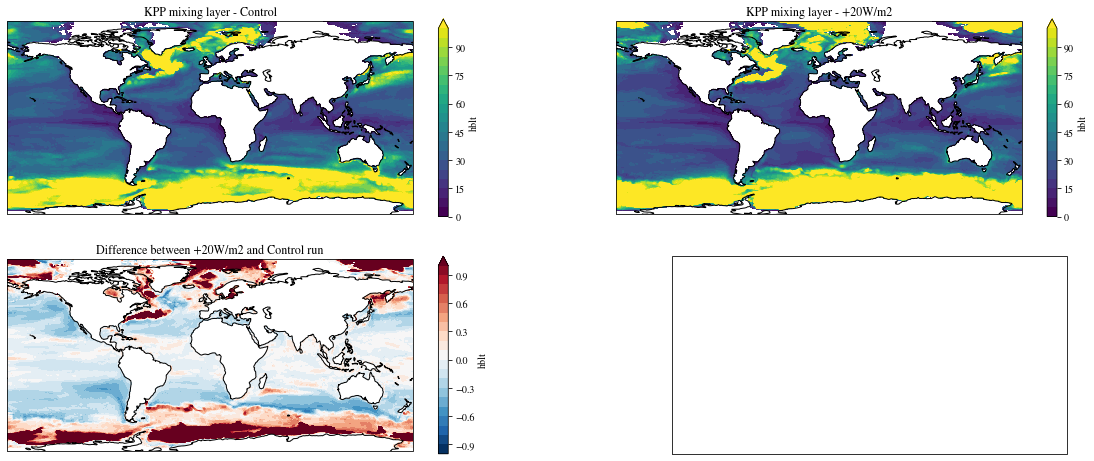

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 8), subplot_kw = {'projection': ccrs.PlateCarree()})

start_time_hblt = start_time_last
end_time_hblt = end_time

for i, j in enumerate(session):
    
    hblt = cc.querying.getvar(expt = expt[i], session = j, variable = 'hblt', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time_last, end_time))
    if(i == 0):
        tmpy = hblt
    elif(i == 1 or i == 2):
        ((hblt - tmpy)/tmpy).mean('time').plot.contourf(ax = axes[1][i-1], levels = np.linspace(-1, 1, 21), transform=ccrs.PlateCarree())
        axes[1][i-1].coastlines()
        axes[1][i-1].set_title('Difference between ' + name[i] + ' and Control run')
    else:
        ((hblt - tmpy)/tmpy).mean('time').plot.contourf(ax = axes[2][i-3], levels = np.linspace(-1, 1, 21), transform=ccrs.PlateCarree())
        axes[2][i-3].coastlines()
        axes[2][i-3].set_title('Difference between ' + name[i] + ' and Control run')
    hblt.mean('time').plot.contourf(ax = axes[int(i/2)][int(i%2)], levels = np.linspace(0, 100, 21), transform=ccrs.PlateCarree())
    axes[int(i/2)][int(i%2)].coastlines()
    axes[int(i/2)][int(i%2)].set_title('KPP mixing layer - ' + name[i])

## Surface temperature

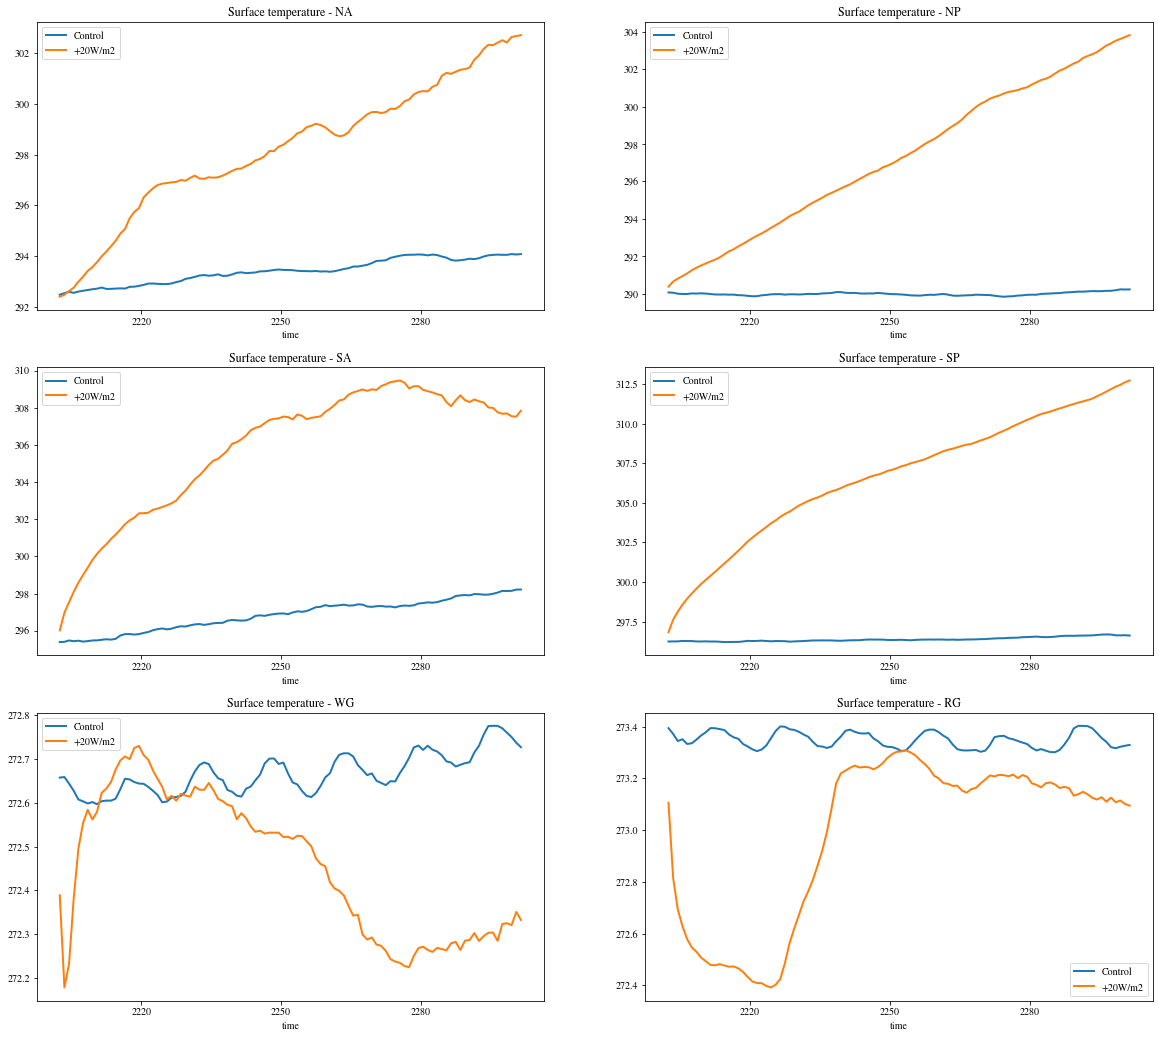

In [9]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time, end_time))
    temp_sfc = temp_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(temp_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        temp_sfc_basin = (temp_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        temp_sfc_basin = temp_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        temp_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface temperature - ' + basin[k])

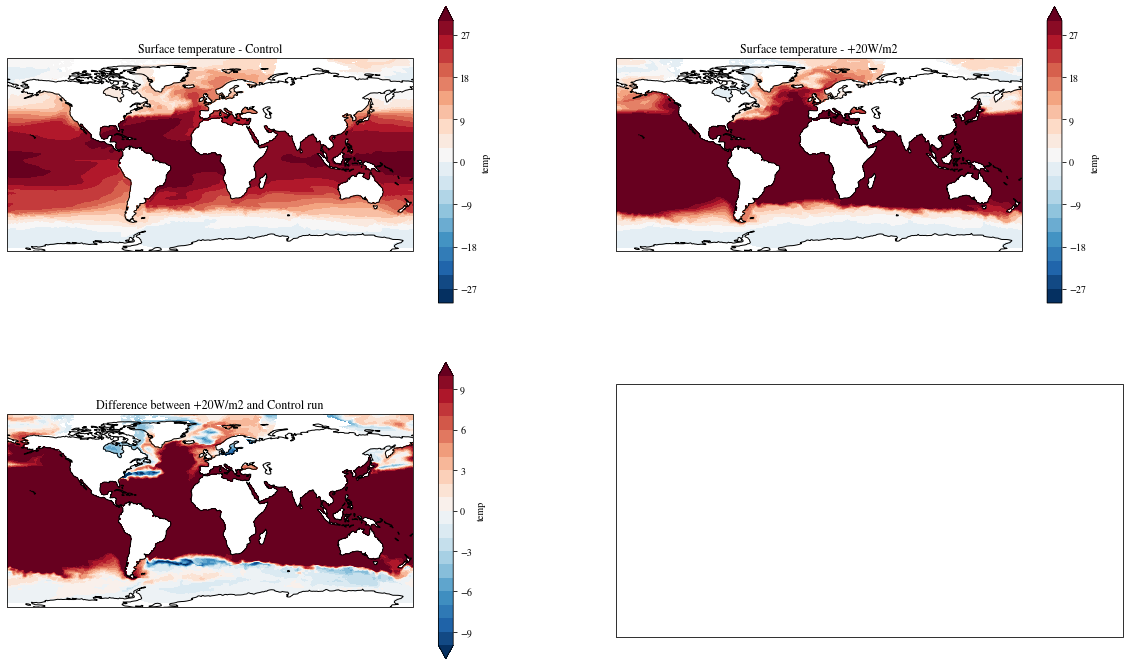

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 8), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time_last, end_time_last))
    temp_sfc = temp_sfc.isel(st_ocean = 1) - 273.15
    #finite_variable = xr.ufuncs.isfinite(temp_sfc)
    
    if(i == 0):
        tmpy = temp_sfc
    elif(i == 1 or i == 2):
        (temp_sfc - tmpy).mean('time').plot.contourf(ax = axes[1][i-1], levels = np.linspace(-10, 10, 21), transform=ccrs.PlateCarree())
        axes[1][i-1].coastlines()
        axes[1][i-1].set_title('Difference between ' + name[i] + ' and Control run')
    else:
        (temp_sfc - tmpy).mean('time').plot.contourf(ax = axes[3][i-3], levels = np.linspace(-10, 10, 21), transform=ccrs.PlateCarree())
        axes[3][i-3].coastlines()
        axes[3][i-3].set_title('Difference between ' + name[i] + ' and Control run')
    
    temp_sfc.mean('time').plot.contourf(ax = axes[int(i/2)][int(i%2)], levels = np.linspace(-30, 30, 21), transform=ccrs.PlateCarree())
    axes[int(i/2)][int(i%2)].coastlines()
    axes[int(i/2)][int(i%2)].set_title('Surface temperature - ' + name[i])

## Surface salinity

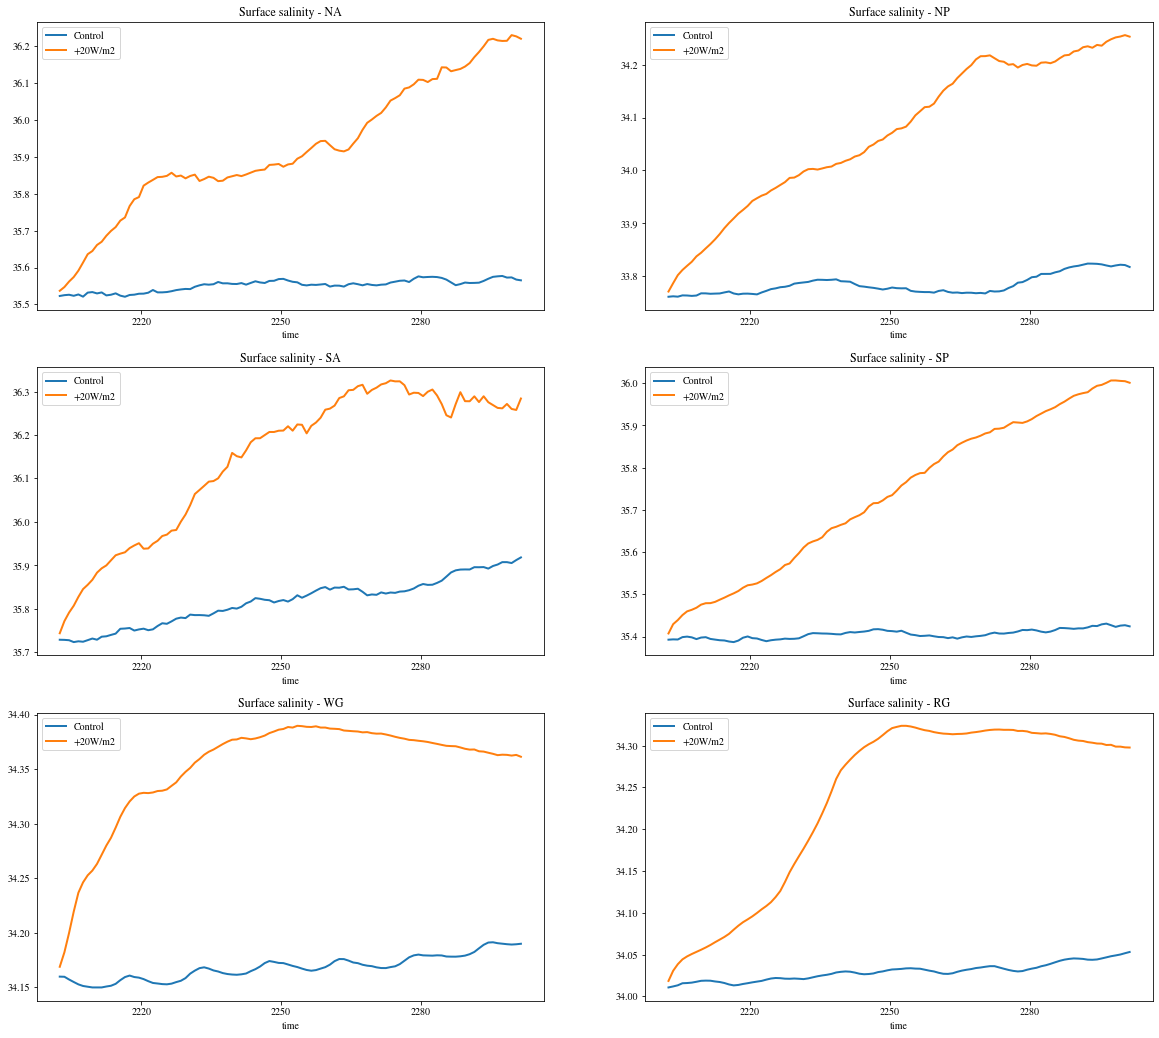

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 18))

for i, j in enumerate(session):
    
    salt_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'salt', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time, end_time))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(salt_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        salt_sfc_basin = (salt_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        salt_sfc_basin = salt_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        salt_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface salinity - ' + basin[k])

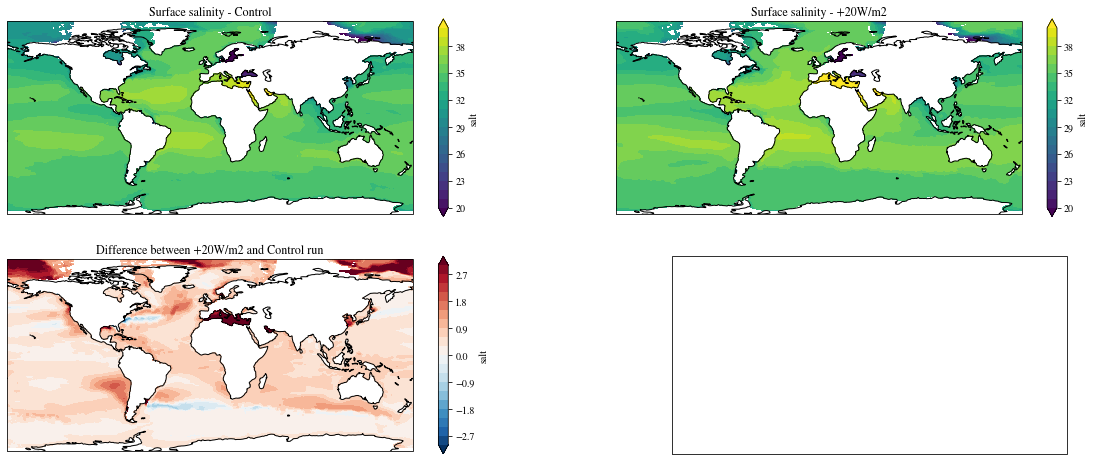

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 8), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    
    salt_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'salt', frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time_last, end_time_last))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    #finite_variable = xr.ufuncs.isfinite(salt_sfc)
    
    if(i == 0):
        tmpy = salt_sfc
    elif(i == 1 or i == 2):
        (salt_sfc - tmpy).mean('time').plot.contourf(ax = axes[1][i-1], levels = np.linspace(-3, 3, 21), transform=ccrs.PlateCarree())
        axes[1][i-1].coastlines()
        axes[1][i-1].set_title('Difference between ' + name[i] + ' and Control run')
    else:
        (salt_sfc - tmpy).mean('time').plot.contourf(ax = axes[3][i-3], levels = np.linspace(-3, 3, 21), transform=ccrs.PlateCarree())
        axes[3][i-3].coastlines()
        axes[3][i-3].set_title('Difference between ' + name[i] + ' and Control run')
    
    salt_sfc.mean('time').plot.contourf(ax = axes[int(i/2)][int(i%2)], levels = np.linspace(20, 40, 21), transform=ccrs.PlateCarree())
    axes[int(i/2)][int(i%2)].coastlines()
    axes[int(i/2)][int(i%2)].set_title('Surface salinity - ' + name[i])

## Surface heat flux

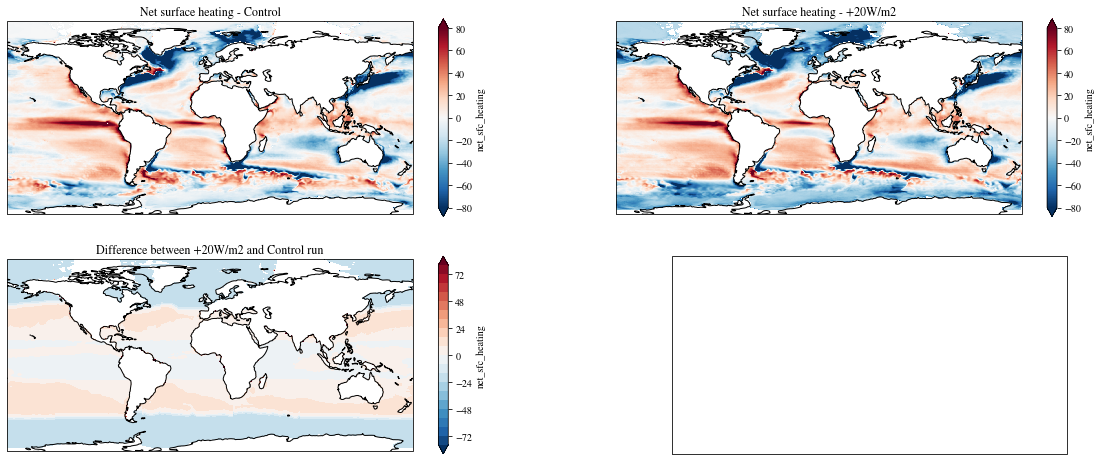

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 8), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, j in enumerate(session):
    
    heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly', use_cftime = True).sel(time = slice(
        start_time_last, end_time_last))
    
    heat.mean('time').plot(ax = axes[int(i/2)][int(i%2)], vmin = -80, vmax = 80, cmap = 'RdBu_r', transform=ccrs.PlateCarree())
    axes[int(i/2)][int(i%2)].coastlines()
    axes[int(i/2)][int(i%2)].set_title('Net surface heating - ' + name[i])
    
    if(i == 0):
        tmpy = heat
    elif(i == 1 or i == 2):
        (heat - tmpy).mean('time').plot.contourf(ax = axes[1][i-1], levels = np.linspace(-80, 80, 21), transform=ccrs.PlateCarree())
        axes[1][i-1].coastlines()
        axes[1][i-1].set_title('Difference between ' + name[i] + ' and Control run')
    else:
        (heat - tmpy).mean('time').plot.contourf(ax = axes[3][i-3], levels = np.linspace(-80, 80, 21), transform=ccrs.PlateCarree())
        axes[3][i-3].coastlines()
        axes[3][i-3].set_title('Difference between ' + name[i] + ' and Control run')

Text(0.5, 1.0, 'Net surface heating - Fractional difference')

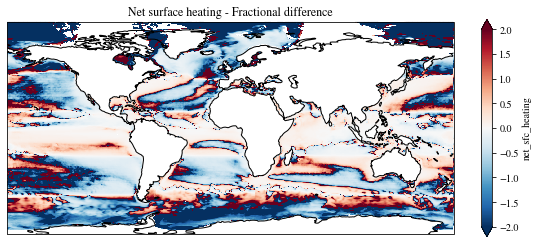

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4), subplot_kw = {'projection': ccrs.PlateCarree()})

heat_cont = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'net_sfc_heating', frequency = '1 monthly', use_cftime = True).sel(time = slice(
        start_time_last, end_time_last))
heat_cont = heat_cont.mean('time')
heat_pert = cc.querying.getvar(expt = expt[1], session = session[1], variable = 'net_sfc_heating', frequency = '1 monthly', use_cftime = True).sel(time = slice(
        start_time_last, end_time_last))
heat_pert = heat_pert.mean('time')

((heat_cont - heat_pert)/heat_cont).plot(ax = axes, vmin = -2, vmax = 2, cmap = 'RdBu_r', transform=ccrs.PlateCarree())
axes.coastlines()
axes.set_title('Net surface heating - Fractional difference')

## Heat flux : Individual contributions

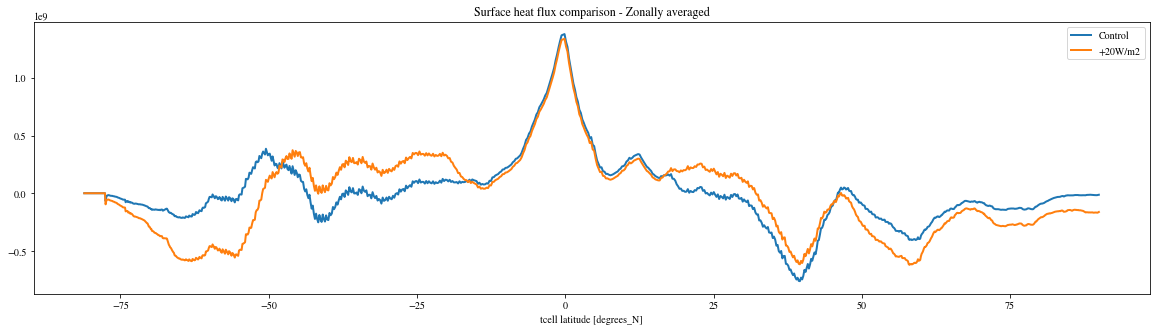

In [16]:
plt.figure(figsize = (20, 5))

var_list = ['swflx', 'lw_heat', 'evap_heat', 'sens_heat']
var_name = ['Shortwave', 'Longwave', 'Latent heat', 'Sensible heat']

start_time_heat = '2202-01-01'
end_time_heat = end_time

for i, j in enumerate(session):
    sum_var = 0
    dxt = cc.querying.getvar(expt = expt[i], variable = 'dxt', session = j, frequency = 'static', n = 1)
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly', use_cftime = True).sel(time = slice(start_time_heat, end_time_heat))
        variable = (variable * dxt).sum(dim = ['xt_ocean'])
        # variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        sum_var = sum_var + variable
    sum_var.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot(label = name[i])
    plt.legend()
    plt.title('Surface heat flux comparison - Zonally averaged')

## Stratification

In [18]:
potrho_2_con = cc.querying.getvar(expt[0], 'pot_rho_2',session = session[0], start_time = start_time_last, 
                       end_time = end_time, use_cftime = True) - 1000#.sel(xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max)) - 1000
potrho_2_buo = cc.querying.getvar(expt[1], 'pot_rho_2',session = session[1], start_time = start_time_last, 
                       end_time = end_time, use_cftime = True) - 1000#.sel(xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max)) - 1000

<a list of 13 text.Text objects>

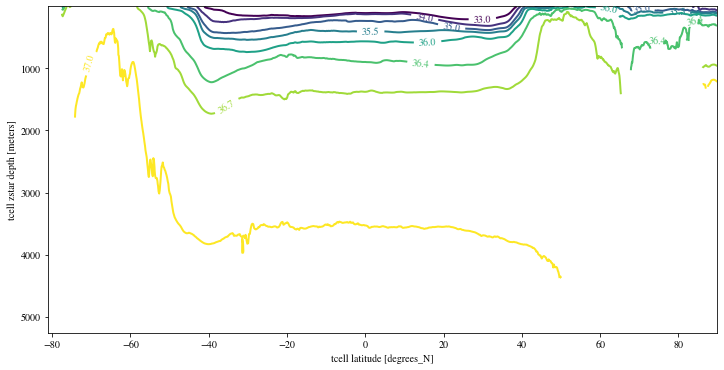

In [19]:
plt.figure(figsize = (12, 6))

ticks = [33, 34, 35, 35.5, 36, 36.4, 36.7, 37]

test_1 = potrho_2_con.mean('time').sel(xt_ocean = slice(-60, -30)).mean('xt_ocean').plot.contour(levels = ticks)
plt.gca().invert_yaxis()
plt.clabel(test_1, inline = True,fontsize = 10)

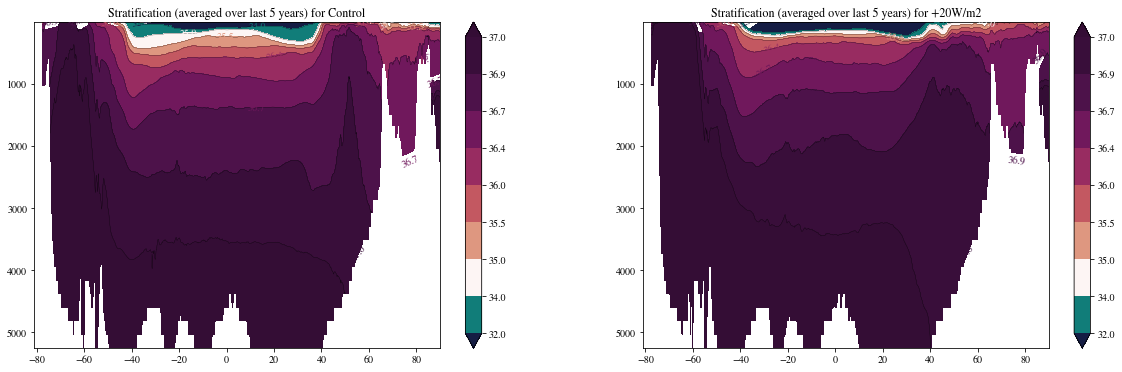

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))

ticks = [32, 34, 35, 35.5, 36, 36.4, 36.7, 36.9, 37]

for i, j in enumerate(session):
    potrho = cc.querying.getvar(expt[i], 'pot_rho_2',session = j, start_time = start_time_last, end_time = end_time, use_cftime = True) - 1000
    mean_pot = potrho.mean('time').sel(xt_ocean = slice(-60, -30)).mean('xt_ocean')

    p1 = ax[int(i%2)].contourf(potrho.yt_ocean, potrho.st_ocean, mean_pot, cmap = cm.cm.curl, levels = ticks, extend = 'both')
    ax[int(i%2)].invert_yaxis()
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i%2)].contour(potrho.yt_ocean, potrho.st_ocean, mean_pot, levels = ticks, colors = 'k', linewidths = 0.25)
    ax[int(i%2)].contour(potrho.yt_ocean, potrho.st_ocean, mean_pot, levels = [0.0,], colors = 'k', linewidths = 0.5)
    plt.clabel(p1, inline = True, fontsize = 10)
    ax[int(i%2)].set_title('Stratification (averaged over last 5 years) for ' + name[i])

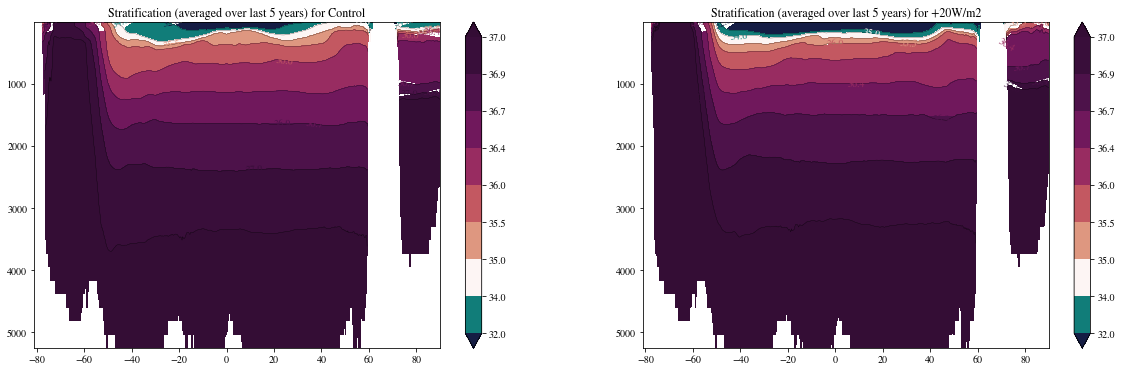

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))

ticks = [32, 34, 35, 35.5, 36, 36.4, 36.7, 36.9, 37]

for i, j in enumerate(session):
    potrho = cc.querying.getvar(expt[i], 'pot_rho_2',session = j, start_time = start_time_last, end_time = end_time, use_cftime = True) - 1000
    mean_pot = potrho.mean('time').sel(xt_ocean = slice(-160, -130)).mean('xt_ocean')

    p1 = ax[int(i%2)].contourf(potrho.yt_ocean, potrho.st_ocean, mean_pot, cmap = cm.cm.curl, levels = ticks, extend = 'both')
    ax[int(i%2)].invert_yaxis()
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i%2)].contour(potrho.yt_ocean, potrho.st_ocean, mean_pot, levels = ticks, colors = 'k', linewidths = 0.25)
    ax[int(i%2)].contour(potrho.yt_ocean, potrho.st_ocean, mean_pot, levels = [0.0,], colors = 'k', linewidths = 0.5)
    plt.clabel(p1, inline = True, fontsize = 10)
    ax[int(i%2)].set_title('Stratification (averaged over last 5 years) for ' + name[i])

## Gyres

In [8]:
rho0 = 1025
start_time_gyre = start_time_last
end_time_gyre = end_time

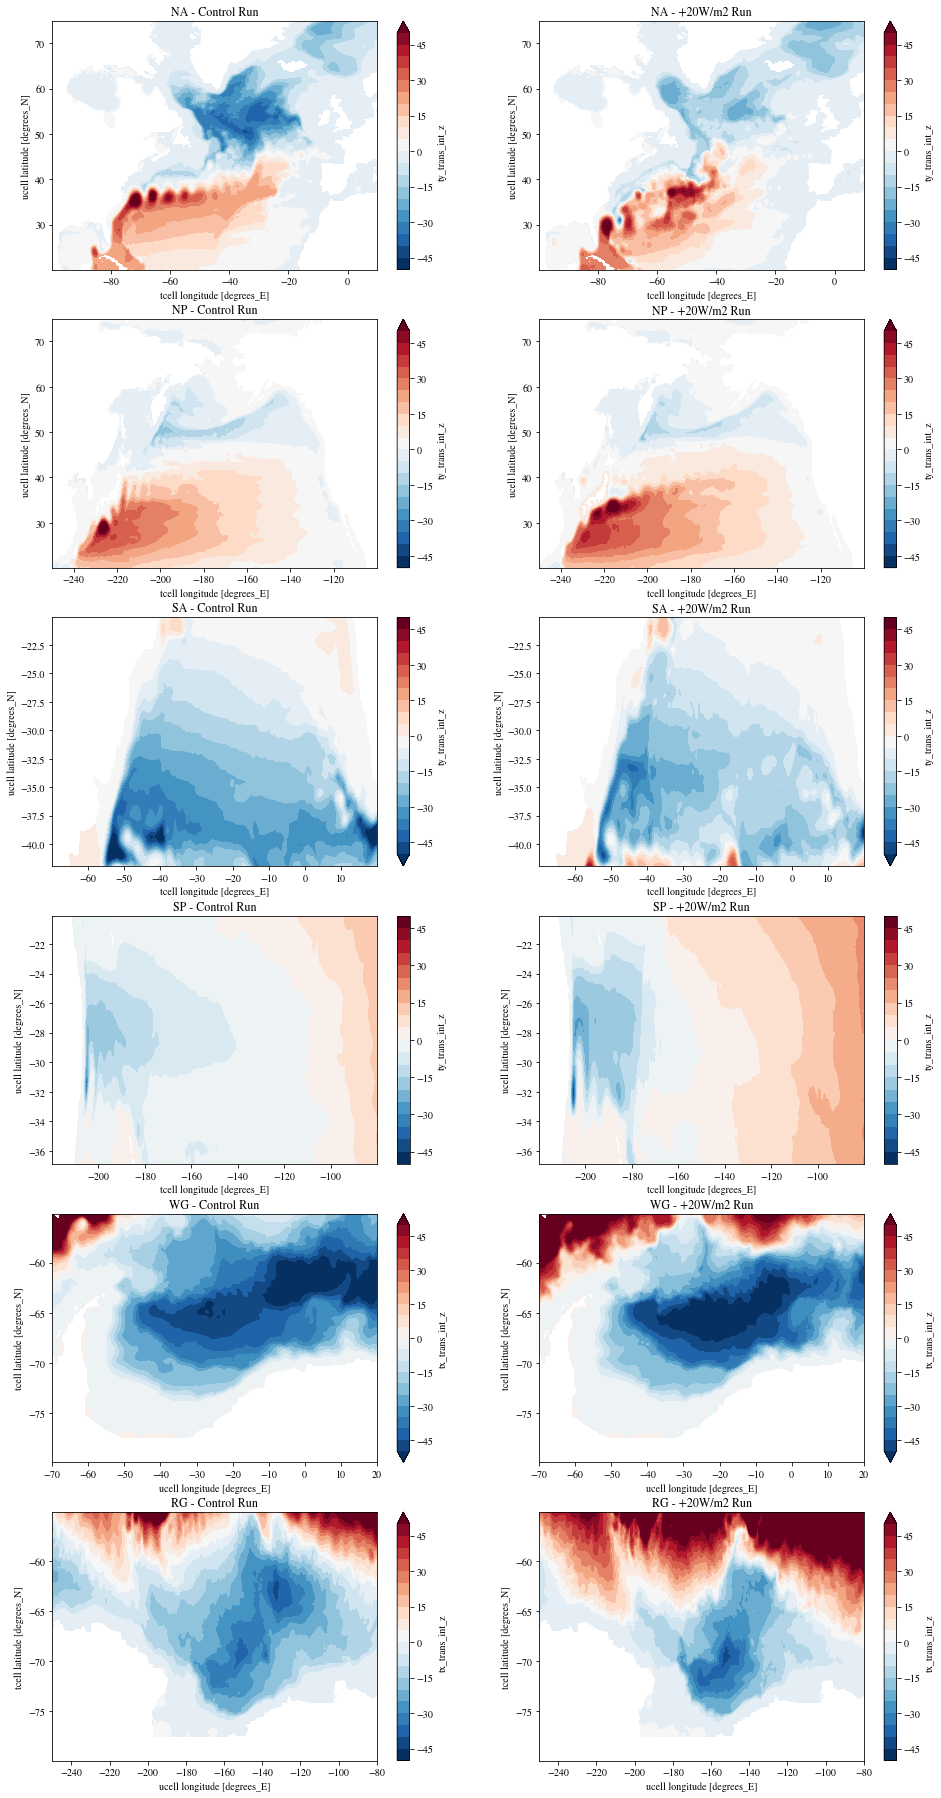

In [23]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (16, 32))

for i, j in enumerate(session):
    tx_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'tx_trans_int_z', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans_int_z', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    net_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    for k, l in enumerate(basin):
        if(l == 'NA' or l == 'NP' or l == 'SA' or l == 'SP'):
            ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
            psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
        else:
            tx_basin = tx_trans.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
            psi_basin = tx_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
            
        psi_basin.sel(time = slice(start_time_gyre, end_time)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-50, 50, 21))
        #net_sfc.sel(time = slice(start_time, end_time)).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k])).mean('time').plot.contour(ax = axes[k][i], cmap = 'PiYG', levels = np.linspace(-100, 100, 7))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

In [9]:
sw = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'wt', n = -1, use_cftime = True).sw_ocean
st_ocean = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'temp', n = -1, use_cftime = True).st_ocean
dzw = sw[1:].values - sw[0:-1].values
dzw = xr.DataArray(data = dzw, dims=["st_ocean"], coords = [st_ocean[0:-1]])

In [10]:
area_t = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'area_t', n = -1, use_cftime = True)
area_u = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'area_u', n = -1, use_cftime = True)

u = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'u', frequency = '1 monthly', n = -1, use_cftime = True)
T = (cc.querying.getvar(expt = expt[0], session = session[0], variable = 'temp', frequency = '1 monthly', n = -1, 
                        use_cftime = True)).sel(st_ocean = 0, method = 'nearest').mean('time')

### North Atlantic region

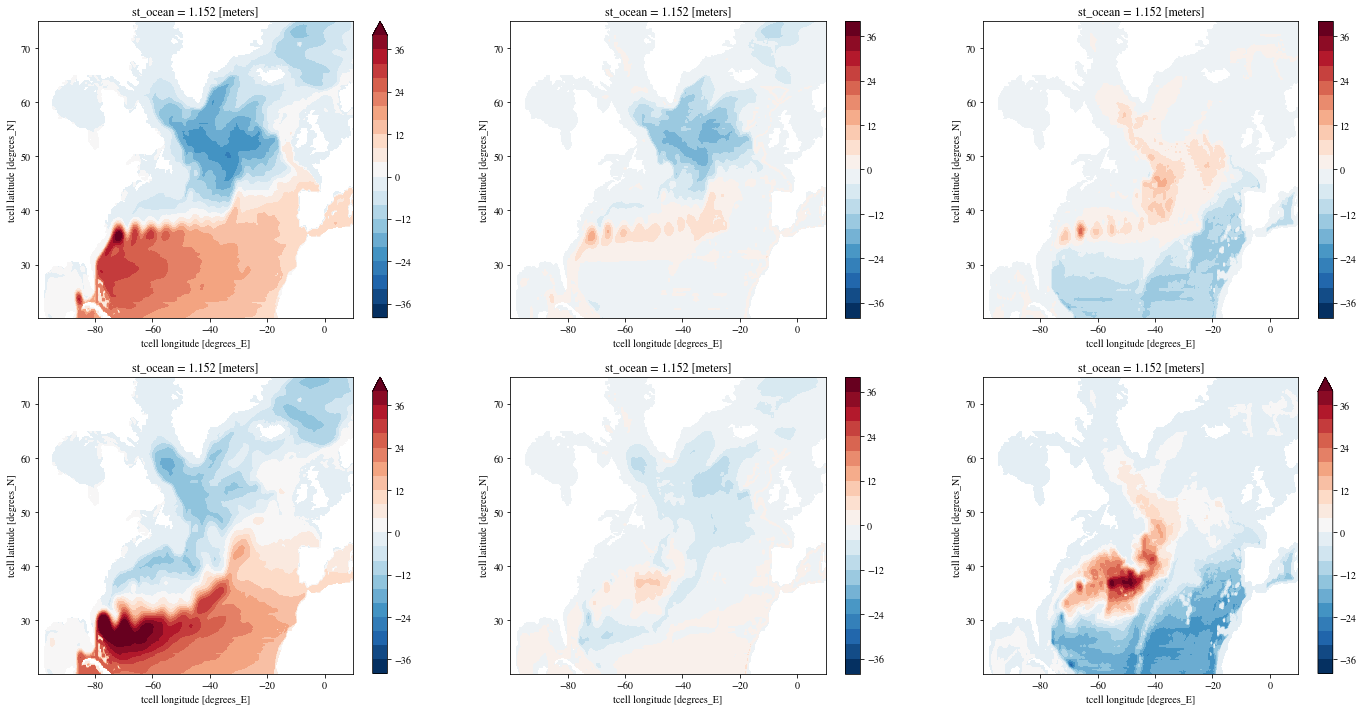

In [26]:
import xgcm

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 12))

#Corresponds with NA region
k = 0

for i, j in enumerate(session):
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    ty_trans = ty_trans.rename('Barotropic transport for each depth')

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, ty_trans))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    ty_trans_interp = temp1.interp(ty_trans, 'Y', boundary = "extend")

    ty_basin = ty_trans_interp.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

    ((psi_basin.sel(st_ocean = slice(0, 500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][0], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(500, 1500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][1], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(1500, 5000)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][2], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    #axes[i][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

In [ ]:
import xgcm

fig, axes = plt.subplots(ncols = 3, figsize = (24, 6))
k = 0

pt_max = [1036.4, 1036.4, 1035]
for i, j in enumerate(session):
    ty_trans_rho = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ty_trans_rho', frequency = '1 monthly', use_cftime = True)#.sel(time = slice('2061-01-01', '2073-12-31'))
    ty_trans_rho = ty_trans_rho.rename({'grid_xt_ocean': 'xt_ocean','grid_yu_ocean': 'yu_ocean'})

    ty_trans_rho = ty_trans_rho.rename('Barotropic transport for each density value')

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, ty_trans_rho))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    ty_trans_rho = temp1.interp(ty_trans_rho, 'Y', boundary = "extend")

    ty_trans_rho = ty_trans_rho.sel(potrho = slice(1028, pt_max[i]))
    rho0 = 1026
    ty_basin = ty_trans_rho.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
    ((psi_basin.sum('potrho').mean(
            'time')*T)/T).plot.contourf(ax = axes[i], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))

### North Pacific region

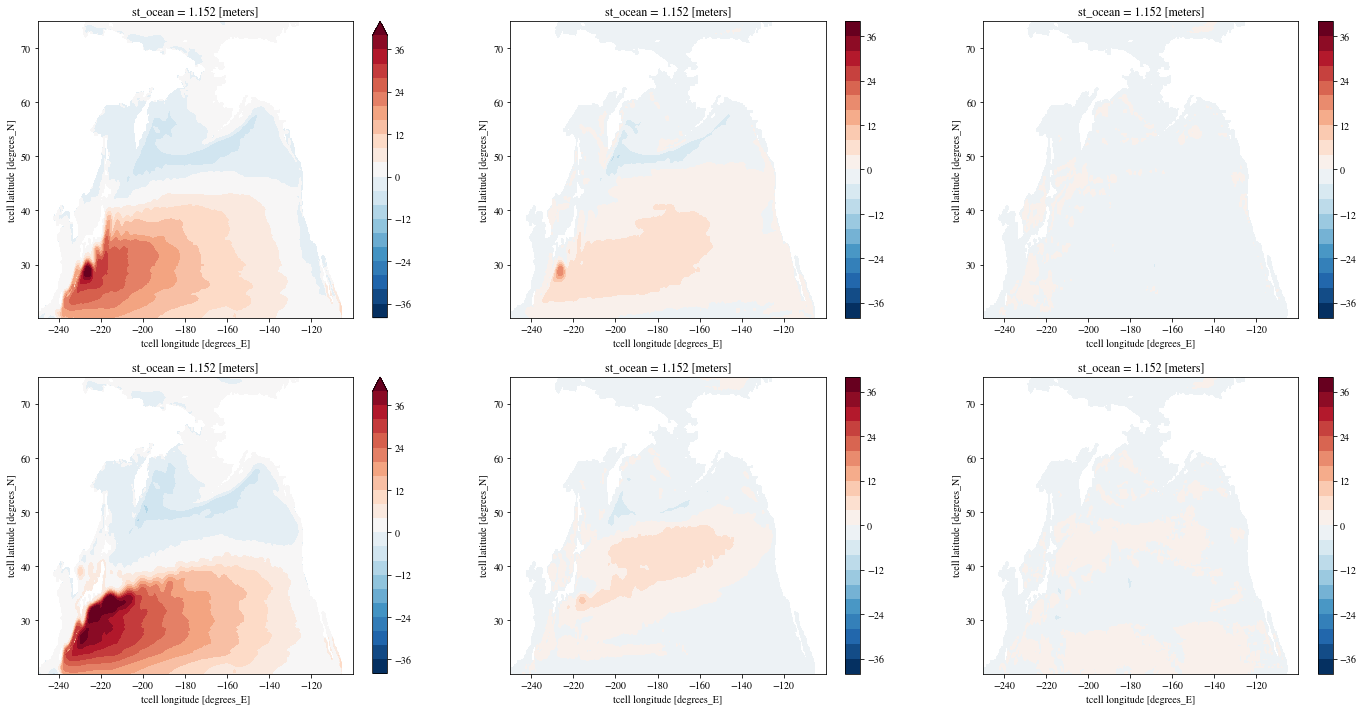

In [20]:
import xgcm

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 12))

#Corresponds with NA region
k = 1

for i, j in enumerate(session):
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    ty_trans = ty_trans.rename('Barotropic transport for each depth')

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, ty_trans))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    ty_trans_interp = temp1.interp(ty_trans, 'Y', boundary = "extend")

    ty_basin = ty_trans_interp.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

    ((psi_basin.sel(st_ocean = slice(0, 500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][0], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(500, 1500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][1], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(1500, 5000)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][2], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    #axes[i][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

### South Atlantic region

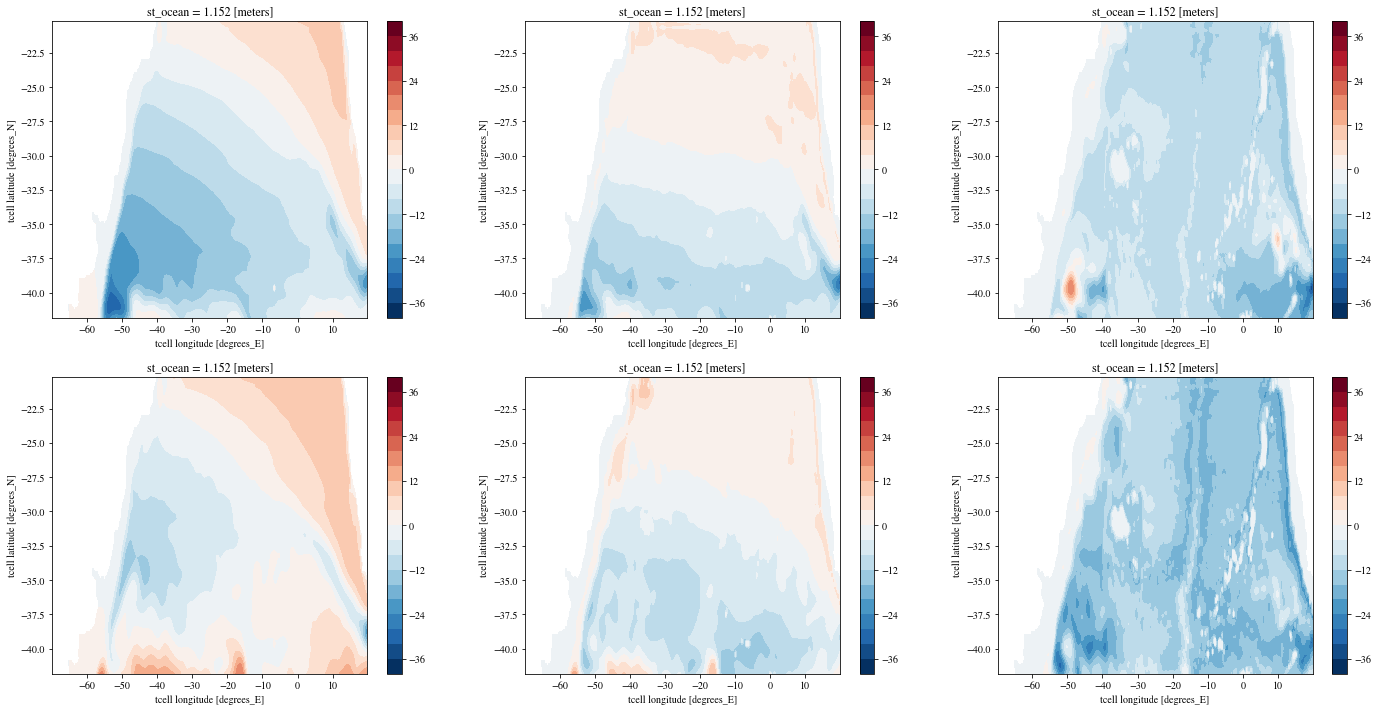

In [21]:
import xgcm

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 12))

#Corresponds with NA region
k = 2

for i, j in enumerate(session):
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    ty_trans = ty_trans.rename('Barotropic transport for each depth')

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, ty_trans))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    ty_trans_interp = temp1.interp(ty_trans, 'Y', boundary = "extend")

    ty_basin = ty_trans_interp.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

    ((psi_basin.sel(st_ocean = slice(0, 500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][0], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(500, 1500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][1], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(1500, 5000)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][2], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    #axes[i][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

### South Pacific region

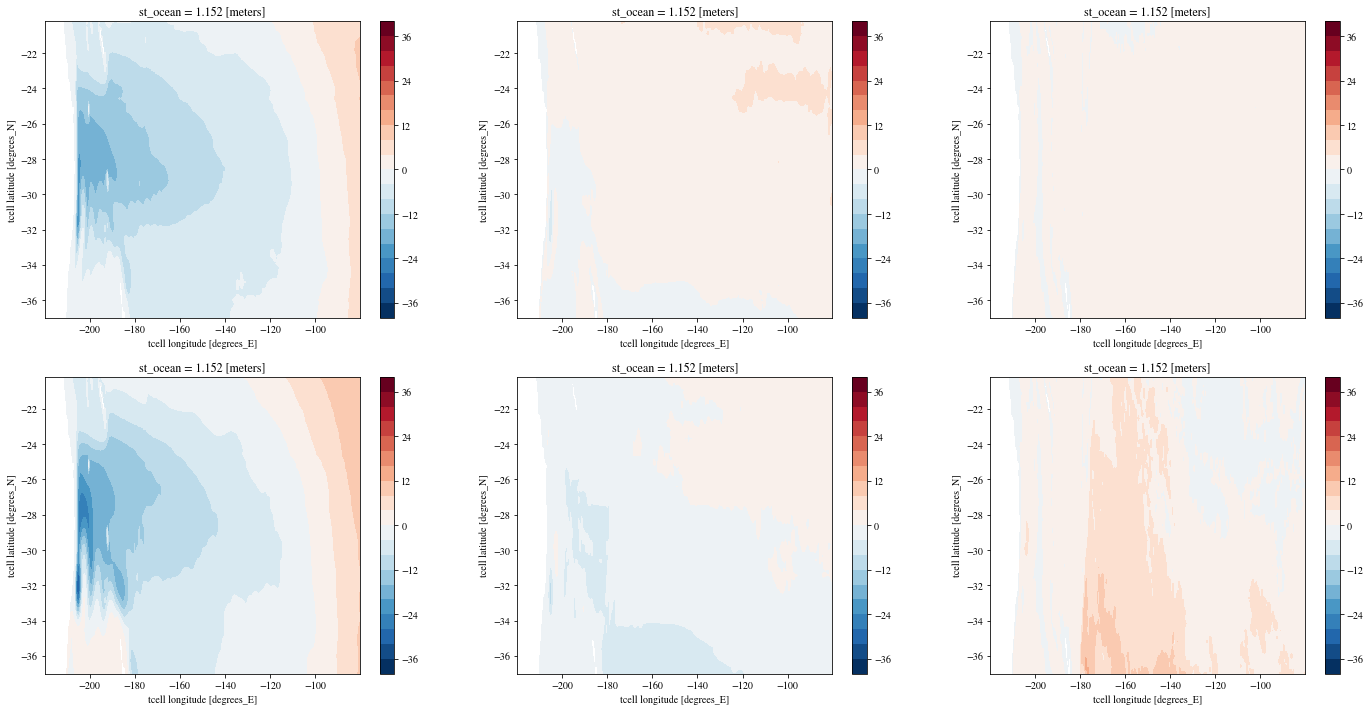

In [22]:
import xgcm

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 12))

#Corresponds with NA region
k = 3

for i, j in enumerate(session):
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans', frequency = '1 monthly', use_cftime = True).sel(
        time = slice(start_time_gyre, end_time_gyre))
    
    ty_trans = ty_trans.rename('Barotropic transport for each depth')

    paths = []
    paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
    data = xr.merge((area_t, area_u, ty_trans))
    data.coords['xu_ocean'].attrs.update(axis='X')
    data.coords['xt_ocean'].attrs.update(axis='X', c_grid_axis_shift = 0.5)
    data.coords['yu_ocean'].attrs.update(axis='Y')
    data.coords['yt_ocean'].attrs.update(axis='Y', c_grid_axis_shift = 0.5)

    temp1 = xgcm.Grid(data, periodic = ['X'])
    ty_trans_interp = temp1.interp(ty_trans, 'Y', boundary = "extend")

    ty_basin = ty_trans_interp.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)

    ((psi_basin.sel(st_ocean = slice(0, 500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][0], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(500, 1500)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][1], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    ((psi_basin.sel(st_ocean = slice(1500, 5000)).sum('st_ocean').sel(time = slice(start_time_gyre, end_time)).mean(
        'time') * T)/T).plot.contourf(ax = axes[i][2], cmap = 'RdBu_r', levels = np.linspace(-40, 40, 21))
    #axes[i][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

## Gyre strength plots - time series

In [ ]:
temp = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'temp_global_ave', frequency = '1 daily', use_cftime = True)
temp = temp.coarsen({"time": 365}, boundary = "trim").mean()

st_gyre = '2204-01-01'
et_gyre = '2297-12-31'
NA_st = temp.sel(time = slice(st_gyre, et_gyre))
NA_sp = temp.sel(time = slice(st_gyre, et_gyre))
NP_st = temp.sel(time = slice(st_gyre, et_gyre))
NP_sp = temp.sel(time = slice(st_gyre, et_gyre))
SA_st = temp.sel(time = slice(st_gyre, et_gyre))
SP_st = temp.sel(time = slice(st_gyre, et_gyre))
WG = temp.sel(time = slice(st_gyre, et_gyre))
RG = temp.sel(time = slice(st_gyre, et_gyre))

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 24))

rho0 = 1025

for i, j in enumerate(session):
    for a in range(2202, 2294):
        st = str(a) + '-01-01'
        et = str(a+4) + '-12-31'
        tx_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'tx_trans', frequency = '1 monthly', 
                                      use_cftime = True).sel(time = slice(st, et)).sel(st_ocean = slice(0, 1500))
        ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans', frequency = '1 monthly', 
                                      use_cftime = True).sel(time = slice(st, et)).sel(st_ocean = slice(0, 1500))

        for k, l in enumerate(basin):
            if(l == 'NA' or l == 'NP'):
                ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
                psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
                psi_basin = psi_basin.sum('st_ocean').mean('time')
            else:
                tx_basin = tx_trans.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
                psi_basin = tx_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
                psi_basin = psi_basin.sum('st_ocean').mean('time')

            if(l == 'NA'):
                NA_st[a-2202] = psi_basin.max().values
                NA_sp[a-2202] = psi_basin.min().values
                
            elif(l == 'NP'):
                NP_st[a-2202] = psi_basin.max().values
                NP_sp[a-2202] = psi_basin.min().values
                
            elif(l == 'SA'):
                SA_st[a-2202] = psi_basin.min().values
            elif(l == 'SP'):
                SP_st[a-2202] = psi_basin.min().values
            elif(l == 'WG'):
                WG[a-2202] = psi_basin.min().values
            elif(l == 'RG'):
                RG[a-2202] = psi_basin.min().values
                
    abs(NA_st).plot(ax = axes[0][0], label = name[i])
    abs(NA_sp).plot(ax = axes[0][1], label = name[i])
    
    abs(NP_st).plot(ax = axes[1][0], label = name[i])
    abs(NP_sp).plot(ax = axes[1][1], label = name[i])
    
    abs(SA_st).plot(ax = axes[2][0], label = name[i])
    abs(SP_st).plot(ax = axes[2][1], label = name[i])
    
    abs(WG).plot(ax = axes[3][0], label = name[i])
    abs(RG).plot(ax = axes[3][1], label = name[i])
    
    axes[0][0].legend()
    axes[0][1].legend()
    axes[1][0].legend()
    axes[1][1].legend()
    axes[2][0].legend()
    axes[2][1].legend()
    axes[3][0].legend()
    axes[3][1].legend()
    
    axes[0][0].set_title('North Atlantic - subtropical gyre')
    axes[0][1].set_title('North Atlantic - subpolar gyre')
    axes[1][0].set_title('North Pacific - subtropical gyre')
    axes[1][1].set_title('North Pacific - subpolar gyre')
    axes[2][0].set_title('South Atlantic - subtropical gyre')
    axes[2][1].set_title('South Pacific - subtropical gyre')
    axes[3][0].set_title('Weddell gyre')
    axes[3][1].set_title('Ross gyre')

## Overturning circulation

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5)) 
#clev = np.arange(-25, 27, 2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1023, 1027, 1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 3.5  ## A power to set teh stretching
start_time_OC = start_time_last
end_time_OC = end_time
rho = 1025 # mean density of sea-water in kg/m^3

for i, j in enumerate(session):
    
    psiGM = cc.querying.getvar(expt[i], 'ty_trans_rho_gm', session = j, start_time = start_time_OC, end_time = end_time_OC, use_cftime = True)
    psiGM = psiGM.sum('grid_xt_ocean')
    psiGM = psiGM / (1e6*rho)
    
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = start_time_OC, end_time = end_time_OC, use_cftime = True)
    psi = psi.sum('grid_xt_ocean').sel(time = slice(start_time_OC, end_time_OC))
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi_avg = psi.cumsum('potrho').mean('time') #- psi.sum('potrho').mean('time')
    
    psi_avg = psi_avg + psiGM.mean('time')

    p1 = ax[int(i%2)].contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1025)**scfac, psi_avg, cmap=cm.cm.curl, levels = clev, extend = 'both')
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1025)**scfac, psi_avg, levels = clev, colors = 'k', linewidths = 0.25)
    ax[int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1025)**scfac, psi_avg, levels = [0.0,], colors = 'k', linewidths = 0.5)

    ax[int(i%2)].set_yticks((yticks-1025)**scfac)
    ax[int(i%2)].set_yticklabels(yticks)
    ax[int(i%2)].set_ylim([0.5**scfac, 14.2**scfac])
    ax[int(i%2)].invert_yaxis()
    ax[int(i%2)].set_ylabel('Potential Density (kg m$^{-3}$)')
    ax[int(i%2)].set_xlabel('Latitude ($^\circ$N)')
    ax[int(i%2)].set_xlim([-75,80])
    ax[int(i%2)].set_title('Overturning for ' + str(name[i]) + ' Run for year 2299');

### Sector overturning

In [10]:
def compute_basin_psi_rho(expt,session, basin_mask, nbound=None, start_time = start_time_OC, end_time = end_time_OC):
    rho = 1025 # mean density of sea-water in kg/m^3
    
    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        print('GM is True')
        psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session, n=nbound,start_time = start_time_OC, end_time = end_time, use_cftime = True)
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6*rho)
    else:
        GM = False
        print('GM is False')
        
    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound,start_time = start_time, end_time = end_time, use_cftime = True)      
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load()
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

GM is True
GM is True
GM is True
GM is True


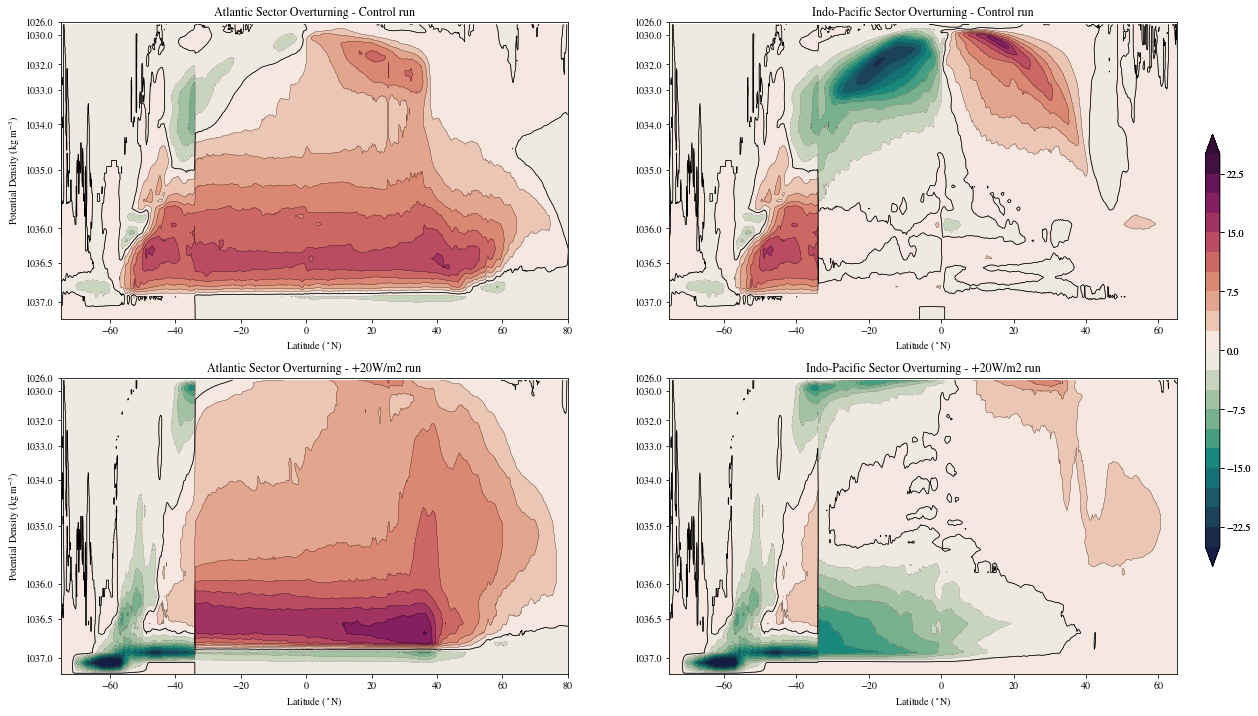

In [11]:
#clev=np.arange(-25,25,2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1026, 1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 3.5  ## A power to set the stretching of the y-axis

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = start_time_OC, end_time = end_time_OC, use_cftime = True)
    ht = cc.querying.getvar(expt[i], 'ht', session = j, n = -1, use_cftime = True)
    land_mask = ~ht.isnull()

    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)
    
    indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

    atlantic_psi = compute_basin_psi_rho(expt[i], j, atlantic_sector_mask, start_time = start_time_OC, end_time = end_time)
    indopacific_psi = compute_basin_psi_rho(expt[i], j, indo_sector_mask, start_time = start_time_OC, end_time = end_time)
    
    p1 = axes[i][0].contourf(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1025)**scfac, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1025)**scfac, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1025)**scfac, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][0].set_yticks((yticks-1025)**scfac)
    axes[i][0].set_yticklabels(yticks)
    axes[i][0].set_ylim([0.5**scfac, 12.2**scfac])
    axes[i][0].invert_yaxis()
    axes[i][0].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i][0].set_xlabel('Latitude ($^\circ$N)')
    axes[i][0].set_xlim([-75,80])
    axes[i][0].set_title('Atlantic Sector Overturning - ' + name[i] + ' run');

    ## Plotting Indo-Pacific Sector
    p1 = axes[i][1].contourf(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1025)**scfac, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1025)**scfac, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1025)**scfac, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][1].set_yticks((yticks-1025)**scfac)
    axes[i][1].set_yticklabels(yticks)
    axes[i][1].set_ylim([0.5**scfac, 12.2**scfac])
    axes[i][1].invert_yaxis()
    axes[i][1].set_xlabel('Latitude ($^\circ$N)')
    axes[i][1].set_xlim([-75,65])
    axes[i][1].set_title('Indo-Pacific Sector Overturning - ' + name[i] + ' run');

    # Plot a colorbar
    cax = plt.axes([0.92, 0.25, 0.01, 0.5])
    cb = plt.colorbar(p1, cax = cax,orientation = 'vertical', ax = axes[i])
    cb.ax.set_xlabel('Sv')

## Global diagnostics

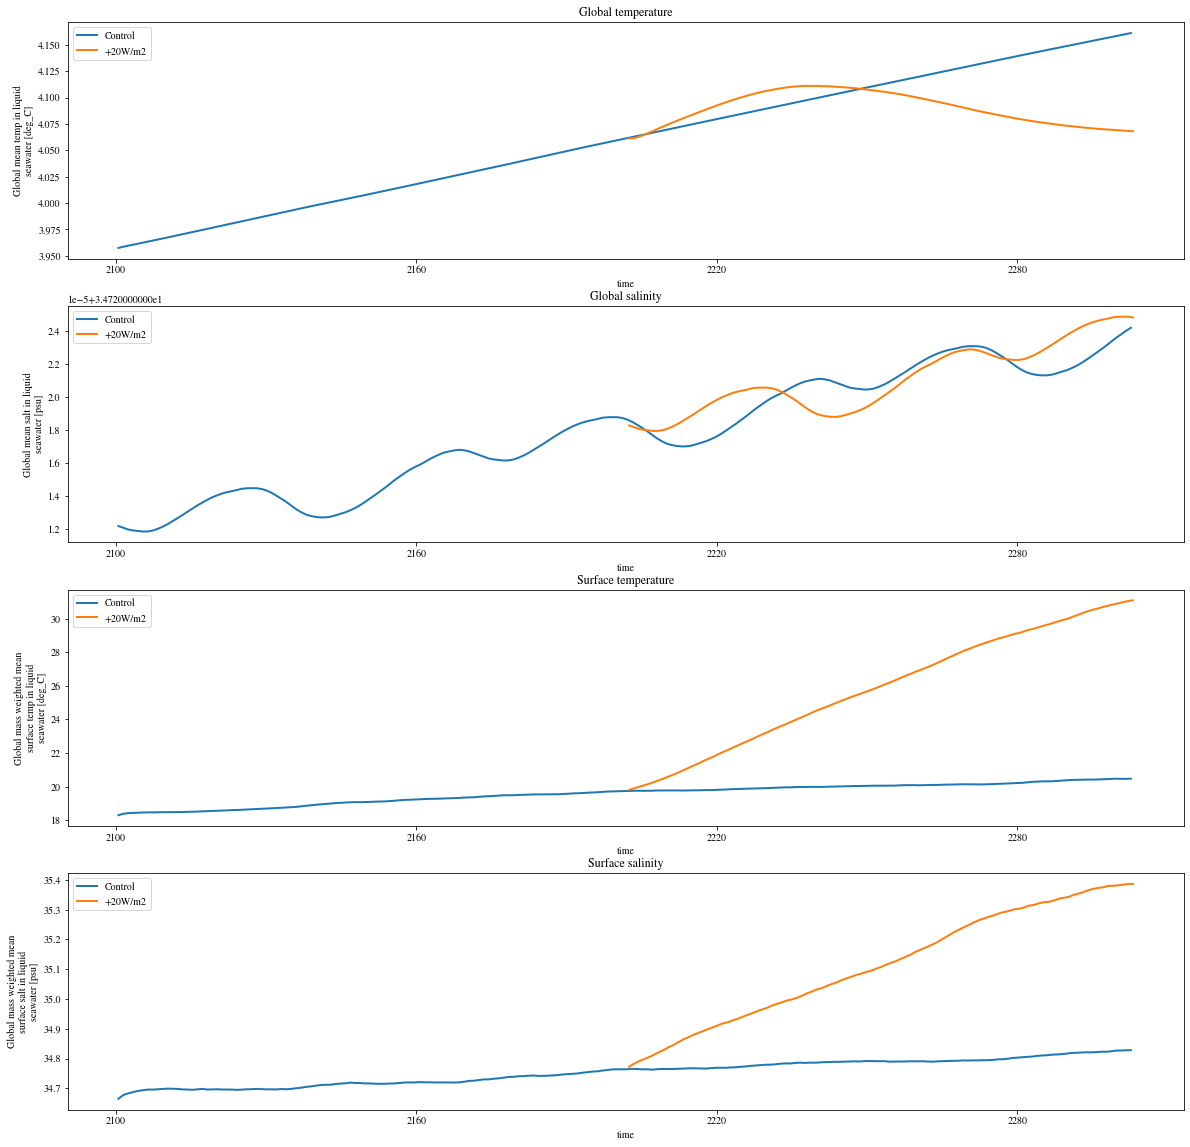

In [12]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l, use_cftime = True)#.sel(time = slice('2000-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

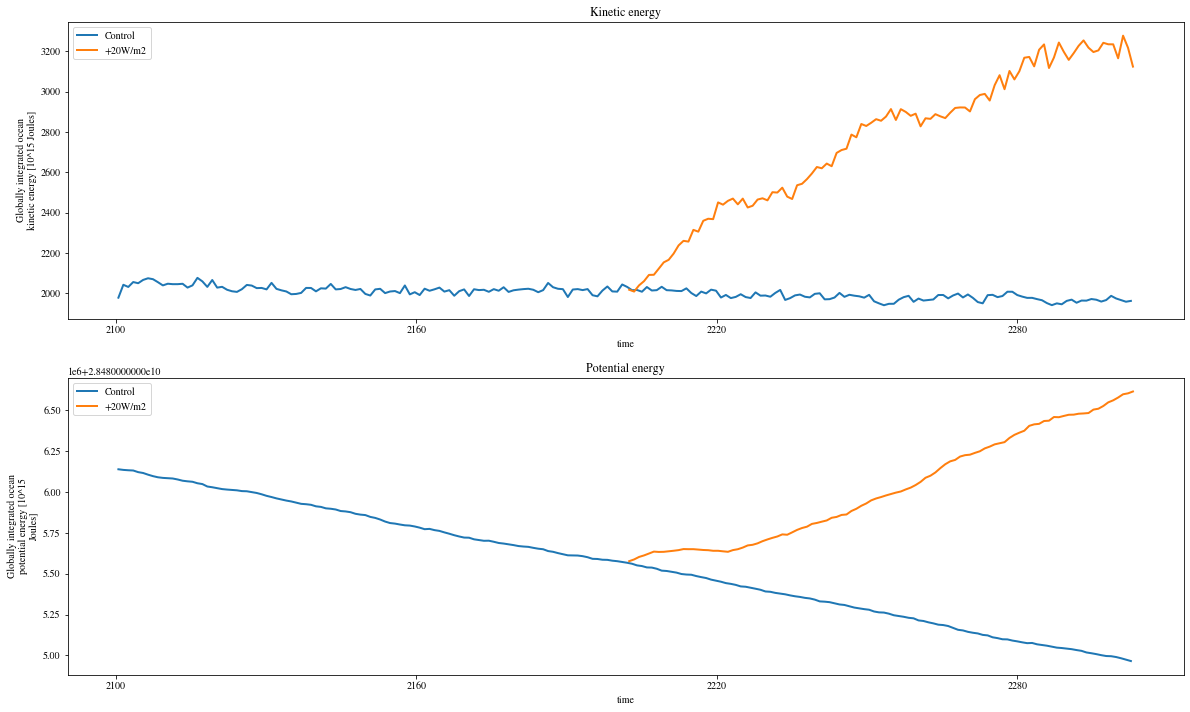

In [13]:
fig, axes = plt.subplots(nrows = 2, figsize = (20, 12))

var_list = ['ke_tot',         'pe_tot'          ]
var_name = ['Kinetic energy', 'Potential energy']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l, use_cftime = True)#.sel(time = slice('2000-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

## Circulation metrics

### ACC Transport

Text(0.5, 1.0, 'Drake Passage Transport')

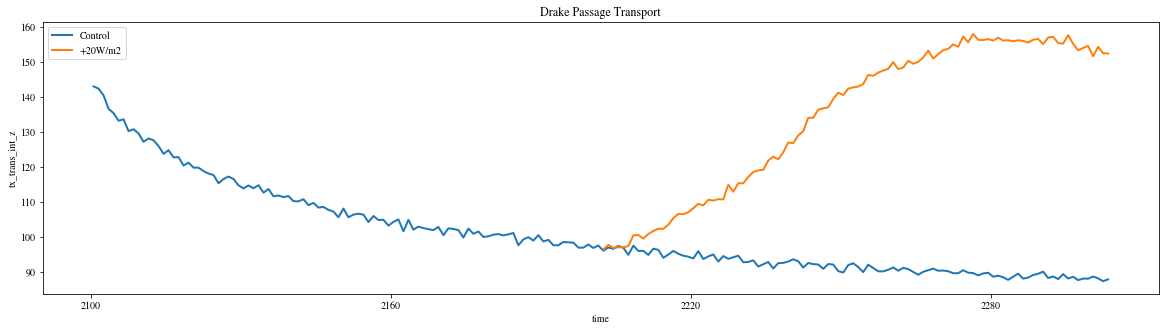

In [15]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, use_cftime = True).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot(label = name[i])
    plt.legend()

plt.title('Drake Passage Transport')

### AABW Circulation

Text(0.5, 1.0, 'AABW Circulation')

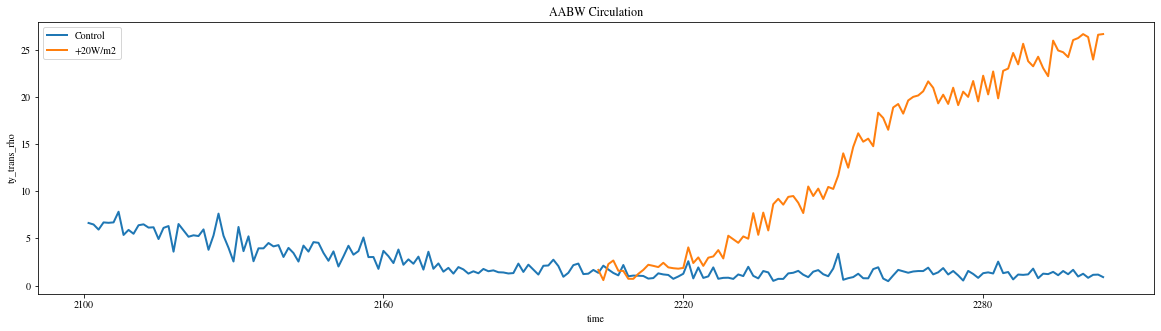

In [16]:
latitude = -45

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_aabw = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, use_cftime = True).sum(
        'grid_xt_ocean').sel(method = 'nearest', grid_yu_ocean = latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho = slice(1036.2, None)).min('potrho').resample(time = 'Y').mean()
    psi_aabw_sum.plot(label = name[i])
    plt.legend()

plt.title('AABW Circulation')

### AMOC

Text(0.5, 1.0, 'AMOC cell')

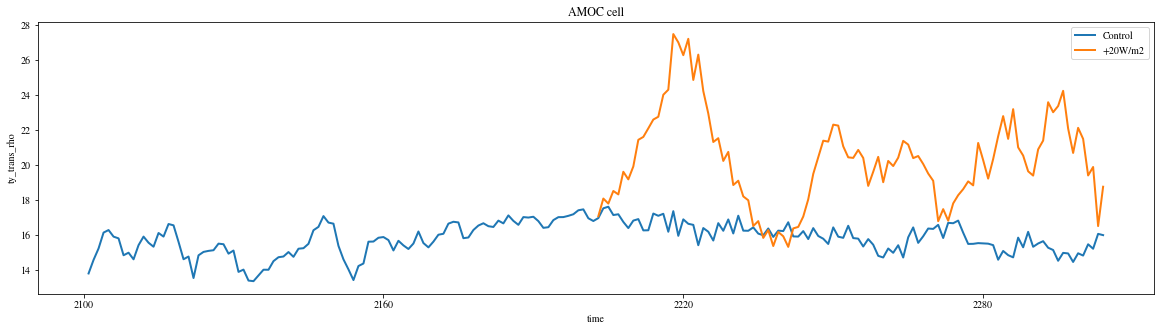

In [17]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, use_cftime = True).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = name[i])
    plt.legend()

plt.title('AMOC cell')

### Gulf stream transport

Text(0.5, 1.0, 'Gulf stream WBC')

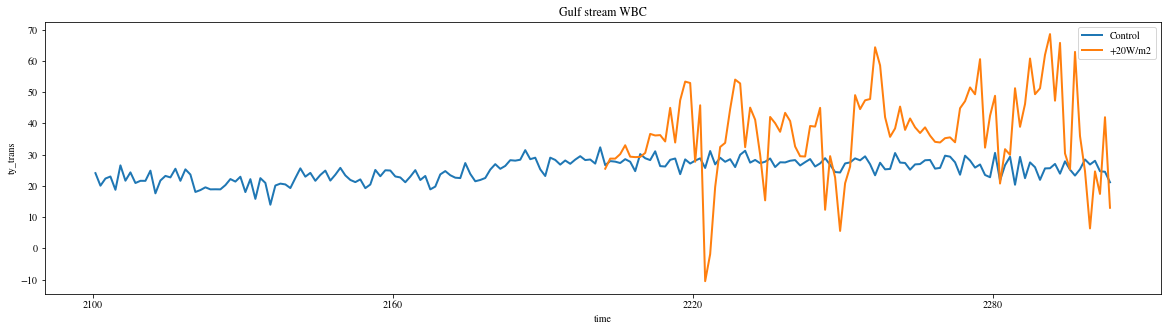

In [18]:
xmin = -80
xmax = -75
ymin = 30
rho0 = 1025

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    GS = cc.querying.getvar(expt[i], 'ty_trans', session = j, use_cftime = True).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sel(st_ocean = slice(0, 2000)).sum('st_ocean').sum('xt_ocean')/rho0/1e6
    GS = GS.coarsen({"time": ncoarse}, boundary = "trim").mean()
    GS.plot(label = name[i])
    plt.legend()

plt.title('Gulf stream WBC')

### Kuroshio current

Text(0.5, 1.0, 'Kuroshio current WBC')

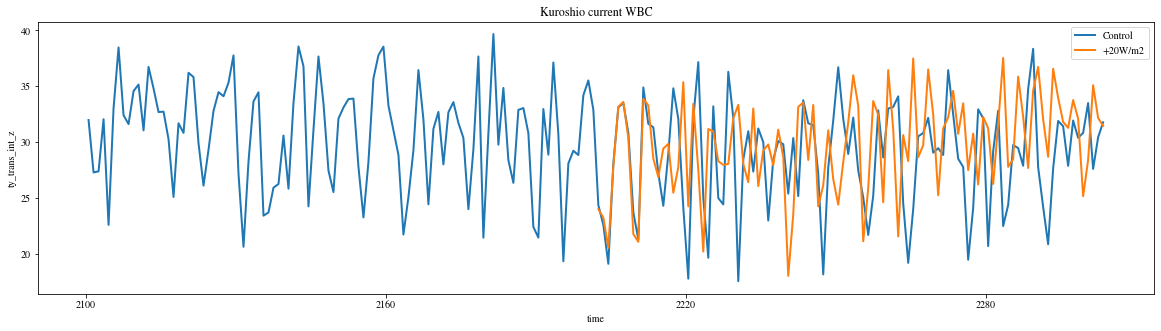

In [19]:
xmin = -235
xmax = -210
ymin = 30
rho0 = 1025

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    KC = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j, use_cftime = True).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    KC = KC.coarsen({"time": ncoarse}, boundary = "trim").mean()
    KC.plot(label = name[i])
    plt.legend()
    
plt.title('Kuroshio current WBC')